# 3D Pathfinding Maze Generation

This notebook demonstrates the procedural generation of a 3D maze and finds a path through it using the A* algorithm. The final output is a manipulable 3D plot showing the maze, the start and end points, and the calculated path.

In [1]:
# Enable the interactive matplotlib backend for Jupyter
# %matplotlib widget

In [2]:
# 3D Pathfinding Example with your updated files
#import python_motion_planning as pmp
import numpy as np
import matplotlib.pyplot as plt
import random
from fontTools.misc.py23 import xrange

from utils.environment.env import Grid, Env
from global_planner.graph_search.a_star import AStar
# from global_planner.graph_search.dijkstra import Dijkstra
# from global_planner.graph_search.jps import JPS
# from global_planner.graph_search.lazy_theta_star import LazyThetaStar
# from global_planner.graph_search.gbfs import GBFS
# from src.Pathfinding3D.utils.plot.plot import Plot
# from src.Pathfinding3D.utils.agent.agent import Robot
# from src.Pathfinding3D.environment3D.node import Node
# from src.Pathfinding3D.utils.planner.planner import Planner

## Environment Setup and Obstacle Generation Functions

These functions are the building blocks for creating the maze structures, including walls, floors, and holes.

In [3]:
# Create environment with custom obstacles
# env = Grid(25, 20, 12)
env = Grid(10, 10, 12)
obstacles = set()
floor_coords = set()

#because it doesn't appear to work during the initialization of the env, or is somehow removed. Either way the shit is busted.
def add_walls(obstacles, env, z0=0, z1=None, thickness=1):
    x, y, z = env.x_range, env.y_range, env.z_range
    for i in range(x+1):
        for j in range(y+1):
            obstacles.add((i, j, 0))  # Floor
            obstacles.add((i, j, z))  # Ceiling

        # XZ faces
    for i in range(x+1):
        for k in range(z+1):
            obstacles.add((i, 0, k))  # Front wall
            obstacles.add((i, y, k))  # Back wall

    # YZ faces
    for j in range(y+1):
        for k in range(z+1):
            obstacles.add((0, j, k))  # Left wall
            obstacles.add((x, j, k))  # Right wall


def add_corner_wall(obstacles, env, z0=0, z1=None, thickness=1):
    """
    Corner wall boundary runs the full length of both sides.
    - corner: (x0, y0) where the two walls meet (e.g., (0,0) for lower-left corner)
    - thickness: how many voxels thick to make each wall (prevents diagonal slips)
    """
    nx, ny, nz = env.x_range, env.y_range, env.z_range # get grid size (x, y, z)

    # if no explicit top height given, use the top layer (last valid z index)
    if z1 is None:
        z1 = nz - 1  # default to last z-index

    x0, y0 = 0, 0  # corner where the two walls meet

    # min(y0 + thickness, ny) clips the stripe so we never exceed the grid height ny
    for x in range(x0, nx):  # span full X: 0..nx-1
        for y in range(y0, min(y0 + thickness, ny)):  # to build a wall Y near y0
            for z in range(z0, z1 + 1):  # # vertical extent from z0 to z1
                obstacles.add((x, y, z))

    # min(x0 + thickness, nx) clips the stripe so we never exceed the grid width nx
    for y in range(y0, ny):  # span full Y: 0..ny-1
        for x in range(x0, min(x0 + thickness, nx)):  # to build a wall X near x0
            for z in range(z0, z1 + 1):  # vertical extent from z0 to z1
                obstacles.add((x, y, z))

def add_floor(obstacles, env, z0=0, thickness=1):
    """
    Add a horizontal obstacle floor spanning the full X and Y dimensions.
    - z0: starting height of the floor
    - thickness: how many layers thick the floor should be
    """
    nx, ny, nz = env.x_range, env.y_range, env.z_range

    # floor spans all x and y, but only thickness layers in z
    for x in range(nx+1):
        for y in range(ny+1):
            for z in range(z0, min(z0 + thickness, nz)):
                obstacles.add((x, y, z))

def add_multi_floors(obstacles, env, holes= None,  z0=0, thickness=1):
    """
    Add a horizontal obstacle floor spanning the full X and Y dimensions.
    - z0: starting height of the floor
    - thickness: how many layers thick the floor should be
    """
    nx, ny, nz = env.x_range, env.y_range, env.z_range

    # floor spans all x and y, but only thickness layers in z
    for x in range(nx+1):
        for y in range(ny+1):
            for z in range(z0, min(z0 + thickness, nz)):
                obstacles.add((x, y, z))

    # remove a block to create a hole in the floor
    if holes:
        for hole in holes:
            if hole in obstacles:
                obstacles.remove(hole)
    # obstacles.remove((x, y, z))
                    
# Build corner wall
add_walls(obstacles, env, z0=0, z1=env.z_range - 1, thickness=1)
# add_corner_wall(obstacles, env, z0=0, z1=env.z_range - 1, thickness=1)
add_floor(obstacles, env, z0=0, thickness=1)
env.update(obstacles)


# First Floor design    
# first_floor_block_coords



# adding random buildings obstacles
random.seed(5)
def generate_random_obstacles(obstacle_amount=20, x_max=25, y_max=20, z_max=12):
    for _ in range(obstacle_amount):
        x = random.randrange(x_max)
        y = random.randrange(y_max)
        height = random.randrange(5, z_max)
        for z in range(height):
            obstacles.add((x, y, z))

def generate_obstacle_gridlike(obstacle_amount=20, x_max=25, y_max=20, z_max=12):
    for x in range(0, 25, 7):
        for y in range(0, 20, 4):
            for z in range(10):
                for i in range(4):
                    for j in range(3):
                        obstacles.add((x + i, y + j, z))

def generate_floor_obstacles(obstacle_coords, floor_ground, floor_height):
    for coords in obstacle_coords:
        x, y = coords[0], coords[1]
        # x = random.randrange(x_max)
        # y = random.randrange(y_max)
        # height = random.randrange(5, z_max)
        for z in range(floor_ground, floor_height):
            obstacles.add((x, y, z))

## Maze Generation and Pathfinding

This cell runs the main logic. It calls the functions above to build the maze, defines the start and goal, and then runs the A* algorithm to find and plot the path.

In [4]:
def generate_3D_maze(env):
    
    floor_height_1 = 4
    holes1=[(2,8,4)]    
    obstacle_coords_1 = [(1,4),(2,5),(3,5),(4,6),(5,7),(6,7), (6,3), (6,4), (7,5), (8,6), (9,7), (2,4),(3,6),(4,7),(7,4),(8,5),(9,6)]
    add_multi_floors(obstacles, env, holes=holes1, z0=floor_height_1, thickness=1)
    generate_floor_obstacles(obstacle_coords_1, 0 ,floor_height_1)
    env.update(obstacles)

    floor_height_2 = 8
    holes2=[(2,8,8),(2,2,8),(8,2,8)]
    # obstacle_coords_2 = [(8,3),(9,3),(7,1),(7,2),(7,3),(7,7),(6,6),(5,5),(3,4),(4,4),(5,4),(5,3),(5,2),(5,1),(6,5),(7,6)]
    obstacle_coords_2 = [(3,8),(3,9),(1,7),(2,7),(3,7),(7,7),(6,6),(5,5),(3,4),(4,4),(5,4),(5,3),(5,2),(5,1),(6,5),(7,6)]
    # obstacle_coords_2 = [(y, x) for (x, y) in obstacle_coords_2]
    add_multi_floors(obstacles, env, holes=holes2, z0=floor_height_2, thickness=1)
    generate_floor_obstacles(obstacle_coords_2, floor_height_1 ,floor_height_2)
    env.update(obstacles)
                
    floor_height_3 = env.z_range
    obstacle_coords_3 = [(1,4),(2,4),(3,4),(2,6),(3,6),(4,6),(5,1),(5,2),(5,3),(5,4),(5,5),(5,6),(5,7),(5,8),(5,9),(6,3),(7,4),(8,4),(8,6),(7,6),(8,7),(9,8),(9,7),(6,2),(7,3)]
    generate_floor_obstacles(obstacle_coords_3, floor_height_2, floor_height_3)
    env.update(obstacles)
    # no holes in the ceiling
    # holes3=[(2,2,8),(8,2,8)]
    # add_multi_floors(obstacles, env, holes=holes3, z0=floor_height_3, thickness=1)

    start_position = (9, 9, 10)
    goal_position = (8, 2, 2)

    return start_position, goal_position

start_position, goal_position = generate_3D_maze(env)

# generate_3D_maze(env)
# generate_obstacles(obstacle_amount=30)
# generate_obstacle_gridlike()

# Update env with new obstacles
env.update(obstacles)

#### Test different algorithms ####
# start_position = (7, 7, 12)
# goal_position = (8, 7, 3)
costs = []

In [ ]:
def simulate_algorithm(algorithm, elev=60, azim=80):
    if start_position in obstacles or goal_position in obstacles:
        print("Start or goal position is inside an obstacle. Aborting.")
        return
        
    print("Running Algorithm:", algorithm.__class__.__name__, "\n")

    planner = algorithm
    cost, path, expand = planner.plan()
    planner.plot.ax.view_init(elev, azim) # rotating plot angle
    planner.plot.animation(path, str(planner), cost, expand=None)
    costs.append(cost)
    
print("New goal position:", goal_position)
simulate_algorithm(AStar(start_position, goal=goal_position, env=env), elev=10, azim=180)
# simulate_algorithm(Dijkstra(start_position, goal=(goal_position), env=env))
# simulate_algorithm(JPS(start_position, goal=(goal_position), env=env))
# simulate_algorithm(LazyThetaStar(start_position, goal=(goal_position), env=env))
# simulate_algorithm(GBFS(start_position, goal=(goal_position), env=env))

## Alternative Visualization with Plotly

The cell below provides a more advanced, interactive 3D visualization using the Plotly library. It performs the same A* pathfinding but renders the output in a smoother, web-based figure that you can easily manipulate.

In [ ]:
import plotly.graph_objects as go

def simulate_with_plotly(algorithm, start_pos, goal_pos, obstacles_set):
    """
    Runs the planning algorithm and visualizes the output using Plotly
    for a richer, more interactive experience.
    """
    print("Running Algorithm:", algorithm.__class__.__name__, "for Plotly visualization\\n")

    # 1. Run the planner to get the path
    cost, path, expand = algorithm.plan()

    if not path:
        print("No path found!")
        # return

    # 2. Prepare data for Plotly
    path_x = [p[0] for p in path]
    path_y = [p[1] for p in path]
    path_z = [p[2] for p in path]

    # 3. Create a Plotly Figure
    fig = go.Figure()

    # --- Voxel/Cube Generation for Obstacles ---
    # Initialize lists to hold the vertices and face definitions for all cubes
    vert_x, vert_y, vert_z = [], [], []
    face_i, face_j, face_k = [], [], []
    
    # For each obstacle, generate the vertices and faces for a cube
    for i, (ox, oy, oz) in enumerate(obstacles_set):
        # Define the 8 vertices of the cube, centered around the obstacle coordinate
        v = i * 8
        vert_x.extend([ox-0.5, ox+0.5, ox+0.5, ox-0.5, ox-0.5, ox+0.5, ox+0.5, ox-0.5])
        vert_y.extend([oy-0.5, oy-0.5, oy+0.5, oy+0.5, oy-0.5, oy-0.5, oy+0.5, oy+0.5])
        vert_z.extend([oz-0.5, oz-0.5, oz-0.5, oz-0.5, oz+0.5, oz+0.5, oz+0.5, oz+0.5])

        # Define the 12 triangles (2 per face) that make up the cube's surface
        face_i.extend([v+0, v+0, v+2, v+2, v+4, v+4, v+6, v+6, v+0, v+0, v+1, v+1])
        face_j.extend([v+1, v+3, v+3, v+6, v+5, v+7, v+7, v+2, v+4, v+5, v+2, v+6])
        face_k.extend([v+2, v+1, v+7, v+3, v+6, v+5, v+5, v+7, v+5, v+4, v+6, v+2])

    # Add the combined mesh of all obstacle cubes to the figure
    fig.add_trace(go.Mesh3d(
        x=vert_x, y=vert_y, z=vert_z,
        i=face_i, j=face_j, k=face_k,
        color='gray',
        opacity=0.2,
        name='Obstacles'
    ))

    # Add the calculated path as a 3D line
    fig.add_trace(go.Scatter3d(
        x=path_x, y=path_y, z=path_z,
        mode='lines',
        line=dict(color='blue', width=8),
        name='Path'
    ))

    # Add distinct markers for the start and goal points
    fig.add_trace(go.Scatter3d(
        x=[start_pos[0]], y=[start_pos[1]], z=[start_pos[2]],
        mode='markers',
        marker=dict(size=10, color='green', symbol='circle'),
        name='Start'
    ))
    fig.add_trace(go.Scatter3d(
        x=[goal_pos[0]], y=[goal_pos[1]], z=[goal_pos[2]],
        mode='markers',
        marker=dict(size=10, color='red', symbol='x'),
        name='Goal'
    ))

    # 4. Configure the layout of the plot
    fig.update_layout(
        title=f'Plotly 3D Visualization for {algorithm.__class__.__name__}',
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis',
            aspectratio=dict(x=1, y=1, z=1),
            camera_eye=dict(x=1.2, y=1.2, z=0.6)
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    # 5. Show the interactive figure
    fig.show()

# Re-create the AStar planner instance and run the new visualization function
planner_for_plotly = AStar(start_position, goal=goal_position, env=env)
simulate_with_plotly(planner_for_plotly, start_position, goal_position, obstacles)

Running Algorithm: AStar for Plotly visualization\n


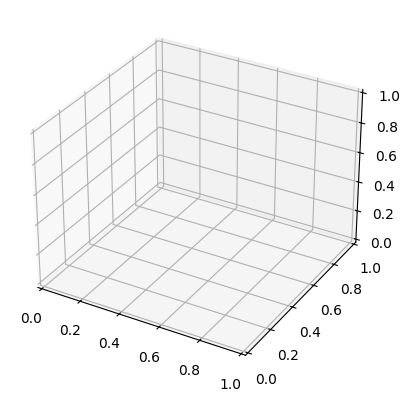

In [7]:
import plotly.graph_objects as go

def simulate_with_plotly(algorithm, start_pos, goal_pos, obstacles_set):
    """
    Runs the planning algorithm and visualizes the output using Plotly
    for a richer, more interactive experience.
    """
    print("Running Algorithm:", algorithm.__class__.__name__, "for Plotly visualization\\n")

    # 1. Run the planner to get the path
    cost, path, expand = algorithm.plan()

    if not path:
        print("No path found!")
        # return

    # --- Filter out boundary obstacles for visualization ---
    floor_height_1 = 4
    floor_height_2 = 8

    internal_obstacles = {
        obs for obs in obstacles_set 
        if 0 < obs[0] < env.x_range  and 
           0 < obs[1] < env.y_range  and 
           0 < obs[2] < env.z_range 
    }
    external_obstacles = obstacles_set - internal_obstacles
    floor_obstacles = {
        obs for obs in internal_obstacles
        if 0 < obs[0] < env.x_range  and 
           0 < obs[1] < env.y_range  and 
           obs[2] in (floor_height_1, floor_height_2)
    }
    maze_obstacles = internal_obstacles - floor_obstacles
    # Add multi_floors coordinates to internal_obstacles for visualization
    

    # 2. Prepare data for Plotly
    path_x = [p[0] for p in path]
    path_y = [p[1] for p in path]
    path_z = [p[2] for p in path]

    # 3. Create a Plotly Figure
    fig = go.Figure()

    # --- Voxel/Cube Generation for Obstacles ---
    # Initialize lists to hold the vertices and face definitions for all cubes
    vert_x, vert_y, vert_z = [], [], []
    face_i, face_j, face_k = [], [], []
    
    # For each obstacle, generate the vertices and faces for a cube
    # for i, (ox, oy, oz) in enumerate(internal_obstacles):
    for i, (ox, oy, oz) in enumerate(maze_obstacles):
        # Define the 8 vertices of the cube, centered around the obstacle coordinate
        v = i * 8
        vert_x.extend([ox-0.5, ox+0.5, ox+0.5, ox-0.5, ox-0.5, ox+0.5, ox+0.5, ox-0.5])
        vert_y.extend([oy-0.5, oy-0.5, oy+0.5, oy+0.5, oy-0.5, oy-0.5, oy+0.5, oy+0.5])
        vert_z.extend([oz-0.5, oz-0.5, oz-0.5, oz-0.5, oz+0.5, oz+0.5, oz+0.5, oz+0.5])

        # Define the 12 triangles (2 per face) that make up the cube's surface
        face_i.extend([v+0, v+0, v+2, v+2, v+4, v+4, v+6, v+6, v+0, v+0, v+1, v+1])
        face_j.extend([v+1, v+3, v+3, v+6, v+5, v+7, v+7, v+2, v+4, v+5, v+2, v+6])
        face_k.extend([v+2, v+1, v+7, v+3, v+6, v+5, v+5, v+7, v+5, v+4, v+6, v+2])

    # Add the combined mesh of all obstacle cubes to the figure
    fig.add_trace(go.Mesh3d(
        x=vert_x, y=vert_y, z=vert_z,
        i=face_i, j=face_j, k=face_k,
        color='gray',
        # opacity=0.7,
        opacity=1,
        name='Obstacles'
    ))

    # Draw floors 
    vert_x, vert_y, vert_z = [], [], []
    face_i, face_j, face_k = [], [], []
    
    # For each obstacle, generate the vertices and faces for a cube
    for i, (ox, oy, oz) in enumerate(floor_obstacles):
        # Define the 8 vertices of the cube, centered around the obstacle coordinate
        v = i * 8
        vert_x.extend([ox-0.5, ox+0.5, ox+0.5, ox-0.5, ox-0.5, ox+0.5, ox+0.5, ox-0.5])
        vert_y.extend([oy-0.5, oy-0.5, oy+0.5, oy+0.5, oy-0.5, oy-0.5, oy+0.5, oy+0.5])
        vert_z.extend([oz-0.5, oz-0.5, oz-0.5, oz-0.5, oz+0.5, oz+0.5, oz+0.5, oz+0.5])

        # Define the 12 triangles (2 per face) that make up the cube's surface
        face_i.extend([v+0, v+0, v+2, v+2, v+4, v+4, v+6, v+6, v+0, v+0, v+1, v+1])
        face_j.extend([v+1, v+3, v+3, v+6, v+5, v+7, v+7, v+2, v+4, v+5, v+2, v+6])
        face_k.extend([v+2, v+1, v+7, v+3, v+6, v+5, v+5, v+7, v+5, v+4, v+6, v+2])

    # Add the combined mesh of all obstacle cubes to the figure
    fig.add_trace(go.Mesh3d(
        x=vert_x, y=vert_y, z=vert_z,
        i=face_i, j=face_j, k=face_k,
        color='blue',
        opacity=0.5,
        name='floor'
    ))
    
    # Draw boundaries
    # vert_x, vert_y, vert_z = [], [], []
    # face_i, face_j, face_k = [], [], []
    
    # # For each obstacle, generate the vertices and faces for a cube
    # for i, (ox, oy, oz) in enumerate(external_obstacles):
    #     # Define the 8 vertices of the cube, centered around the obstacle coordinate
    #     v = i * 8
    #     vert_x.extend([ox-0.5, ox+0.5, ox+0.5, ox-0.5, ox-0.5, ox+0.5, ox+0.5, ox-0.5])
    #     vert_y.extend([oy-0.5, oy-0.5, oy+0.5, oy+0.5, oy-0.5, oy-0.5, oy+0.5, oy+0.5])
    #     vert_z.extend([oz-0.5, oz-0.5, oz-0.5, oz-0.5, oz+0.5, oz+0.5, oz+0.5, oz+0.5])

    #     # Define the 12 triangles (2 per face) that make up the cube's surface
    #     face_i.extend([v+0, v+0, v+2, v+2, v+4, v+4, v+6, v+6, v+0, v+0, v+1, v+1])
    #     face_j.extend([v+1, v+3, v+3, v+6, v+5, v+7, v+7, v+2, v+4, v+5, v+2, v+6])
    #     face_k.extend([v+2, v+1, v+7, v+3, v+6, v+5, v+5, v+7, v+5, v+4, v+6, v+2])

    # # Add the combined mesh of all obstacle cubes to the figure
    # fig.add_trace(go.Mesh3d(
    #     x=vert_x, y=vert_y, z=vert_z,
    #     i=face_i, j=face_j, k=face_k,
    #     color='gray',
    #     opacity=0.02,
    #     name='Boundary'
    # ))

    # Add the calculated path as a 3D line
    fig.add_trace(go.Scatter3d(
        x=path_x, y=path_y, z=path_z,
        mode='lines',
        line=dict(color='red', width=9),
        name='Path'
    ))

    # Add distinct markers for the start and goal points
    fig.add_trace(go.Scatter3d(
        x=[start_pos[0]], y=[start_pos[1]], z=[start_pos[2]],
        mode='markers',
        marker=dict(size=10, color='green', symbol='circle'),
        name='Start'
    ))
    fig.add_trace(go.Scatter3d(
        x=[goal_pos[0]], y=[goal_pos[1]], z=[goal_pos[2]],
        mode='markers',
        marker=dict(size=10, color='red', symbol='x'),
        name='Goal'
    ))

    # 4. Configure the layout of the plot
    fig.update_layout(
        title=f'Plotly 3D Visualization for {algorithm.__class__.__name__}',
        scene=dict(
            xaxis_title='X Axis',
            yaxis_title='Y Axis',
            zaxis_title='Z Axis',
            aspectratio=dict(x=1, y=1, z=1),
            camera_eye=dict(x=1.2, y=1.2, z=0.6)
        ),
        margin=dict(l=0, r=0, b=0, t=40)
    )

    # 5. Show the interactive figure
    fig.show()

# Re-create the AStar planner instance and run the new visualization function
planner_for_plotly = AStar(start_position, goal=goal_position, env=env)
simulate_with_plotly(planner_for_plotly, start_position, goal_position, obstacles)